## Driver analysis

This notebook is intended to analyze somatic mutations from TCGA to implicate putative driver genes in the Ubiquitin-Proteasome System (UPS) or UPS substrates.

In [7]:
# import needed packages
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import scipy.stats as stats
import matplotlib as mpl
from matplotlib_venn import venn2, venn2_circles
mpl.rcParams['pdf.fonttype'] = 42
import utils

### UPS driver gene analysis

First, we look at the characteristics of the putative driver genes identify by the method 20/20+. 20/20+ is a machine learning method that predicts if a gene, when mutated, is an oncogene, tumor suppressor gene, or driver gene (in general). Low scores mean that a gene is likely to be a passenger gene.

In [2]:
# read in the number of significant genes
driver_result = utils.read_driver_gene_results(path='data/ups_driver_gene/2020plus/')
signif_genes = set(
    g for k in driver_result
    for g in driver_result[k]
)

# read in the maximum OG/TSG score for each UPS gene
max_df = pd.read_csv('data/ups_driver_gene/max_og_tsg_scores.txt', sep='\t')

Now plot each gene along their spectrum of oncogene-like and tumor-suppressor-like based on the scores from 20/20+. The plot below uses the maximum score across all analyses.

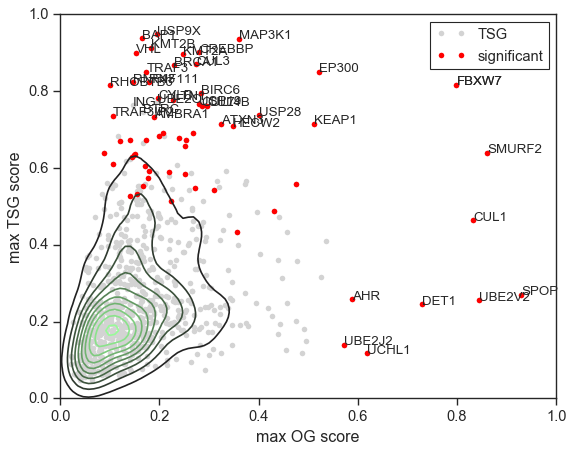

In [4]:
with sns.axes_style('ticks'), sns.plotting_context('notebook', font_scale=1.2):
    # plot every data point
    plt.plot('OG', 'TSG',  '.', data=max_df, color='lightgray',
             mew=0, markersize=10, label=None)
    plt.xlim(0,1)
    plt.ylim(0,1)
    
    # plot significant
    plt.plot('OG', 'TSG',  '.', data=max_df[max_df['gene'].isin(signif_genes)], color='red',
             mew=0, markersize=10, label='significant')
    plt.legend(loc='best')
    
    # label genes in scatter plot
    for ix, row in max_df[max_df['TSG']>0.7].iterrows():
        plt.text(row['OG'], row['TSG'], row['gene'], size=12)
    for ix, row in max_df[max_df['OG']>0.55].iterrows():
        plt.text(row['OG'], row['TSG'], row['gene'], size=12)
    
    # create level sets to show density of scatter plot
    pal = sns.dark_palette("palegreen", as_cmap=True)
    sns.kdeplot(max_df['OG'], max_df['TSG'], cmap=pal, zorder=10, label=None)
    
    # label axes
    plt.ylabel('max TSG score')
    plt.xlabel('max OG score')
    plt.savefig('figures/og_tsg_score.pdf')

### Venn Diagram

Next, we examine the overlap of our driver gene predictions with previously reported results: Ge et al. analysis found 23 UPS driver genes, the Cancer Gene Census, and the previous TCGA PancanAtlas analysis.

In [5]:
# list of significant genes Identified by Ge et al.
ge_et_al_drivers = [
    'ZBTB7B', 'ZBTB20', 'VHL', 'UBE2A', 'TLE1', 'SPOP', 'RNF43',
    'NSD1', 'MAP3K1', 'LZTR1', 'KEAP1', 'KDM5C', 'FBXW7',
    'FBXO7', 'EP300', 'CUL3', 'CREBBP', 'CHD4', 'CHD3', 'CDH1',
    'BRWD3', 'BRCA1', 'BAP1'
]

# cancer gene census genes
cgc = utils.process_cgc('data/misc/Census_allSat Jan  7 18-57-49 2017.tsv')

# tcga driver genes
tcga_drivers = pd.read_table('data/misc/TCGA_pancanatlas_drivers.txt')

# read the complete list of annotated UPS genes
complete_ups = pd.read_table('data/misc/ups_list_only_literature.txt')['gene'].unique()

Venn diagram of the overlap betwen lists of driver genes.

{'001': 207, '010': 6, '011': 4, '100': 46, '101': 4, '110': 3, '111': 10}

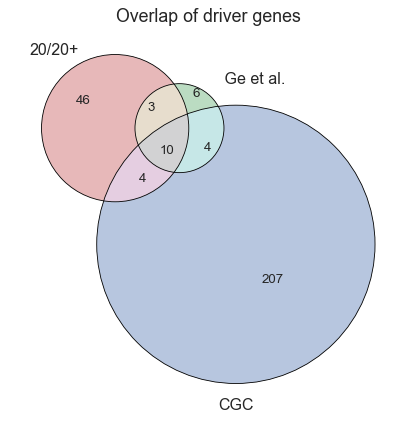

In [13]:
utils.venn_diagram3(signif_genes, set(ge_et_al_drivers), set(cgc),
                   '20/20+', '     Ge et al.',  'CGC',
                   title='Overlap of driver genes')
#plt.savefig('figures/driver_gene_overlap.pdf')

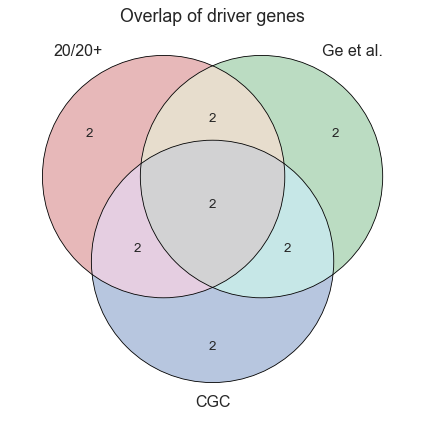

In [15]:
from matplotlib_venn import venn3, venn3_circles
# toy venn diagram to make sure venn circles are even
set1 = set(['A', 'B', 'C', 'D', 'X', 'Y', 'S', 'T'])
set2 = set(['C', 'D', 'E', 'F', 'X', 'Y', 'U', 'V'])
set3 = set(['E', 'F','G', 'H', 'X', 'Y', 'S', 'T'])

utils.venn_diagram3(set1, set2, set3,
                    '20/20+', 'Ge et al.',  'CGC',
                    title='Overlap of driver genes')
plt.savefig('figures/venn_diagram_equal_size.pdf')

Next, we performed a one-tailed fisher exact test for enrichment in the driver genes list from the TCGA PancanAtlas, Ge et al. and Cancer Gene Census (CGC).

In [16]:
def enrichment_test(genes_of_interest, comparison, ups_genes):
    # restrict to UPS
    comparison = set(comparison) & set(ups_genes)
    # overlap two lists
    ovlp = utils.overlap_set(genes_of_interest, comparison, n=len(set(ups_genes)))
    # perform fisher test
    result = stats.fisher_exact(ovlp, alternative='greater')
    return result

# test for enrichment
or1, pval1 = enrichment_test(signif_genes, tcga_drivers.Gene.unique(), complete_ups)
or2, pval2 = enrichment_test(signif_genes, ge_et_al_drivers, complete_ups)
or3, pval3 = enrichment_test(signif_genes, cgc, complete_ups)

# print out results
print('Enrichment for TCGA PancanAtlas: p={:.1g}'.format(pval1))
print('Enrichment for Ge et al.: p={:.1g}'.format(pval2))
print('Enrichment for CGC: p={:.1g}'.format(pval3))

Enrichment for TCGA PancanAtlas: p=3e-25
Enrichment for Ge et al.: p=4e-12
Enrichment for CGC: p=1e-11


In [17]:
len(set(signif_genes) - set(tcga_drivers.Gene.unique()) - set(ge_et_al_drivers) - set(cgc))

38

### Gene ontology enrichment

We performed gene ontology enrichment from DAVID to see if there were any biological processes that were enriched.

In [18]:
df = pd.read_table('data/ups_driver_gene/david_gene_enrichment_with_ups_background.txt')
df['FDR'] = df['FDR'] / 100
df['GO term'] = df['Term'].str.split('~', expand=True)[1]

def format_term(x):
    str_split = x.split(' ')
    split_len = len(str_split)
    if split_len>20:
        return ' '.join(str_split[:split_len//2]) + '\n' + ' '.join(str_split[split_len//2:])
    else:
        return x
    
df['GO term'] = df['GO term'].apply(format_term)

We found processes related to cell proliferation/apoptosis, response to DNA damage, and transcriptional regulation particularly pertaining to hypoxia.

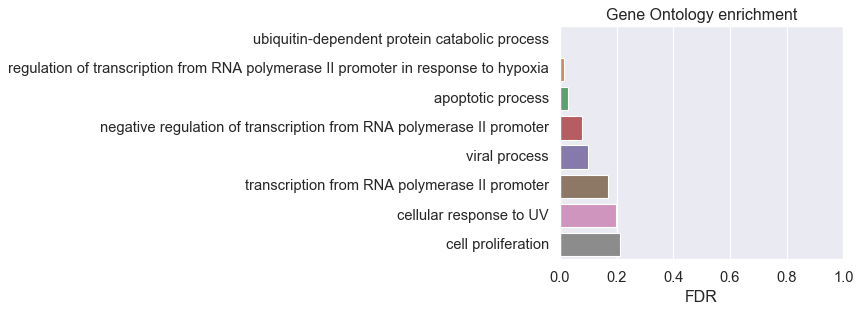

In [19]:
with sns.plotting_context('notebook', font_scale=1.2):
    sns.barplot(y='GO term', x='FDR', data=df[df['FDR']<0.25])
    plt.ylabel('')
    plt.xlim(0,1)

    plt.gcf().set_size_inches(11,4)
    plt.tight_layout()
    plt.title('Gene Ontology enrichment')
    plt.savefig('figures/go_enrichment.pdf')


### Examine tissue expression

Here, we examine how widely expressed UPS driver genes are relative to other genes in the UPS and genes outside of the UPS pathway.

In [20]:
# read data, units are median TPM across samples in a tissue
gtex_df = pd.read_table('data/gtex_essentiality/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_median_tpm.gct')
protein_coding_df = pd.read_table('data/gtex_essentiality/ensembl_biomart_v95_protein_coding_genes.txt')
protein_coding_genes = protein_coding_df['Gene name'].unique()
is_protein_coding = gtex_df['Description'].isin(protein_coding_genes)
gtex_df = gtex_df[is_protein_coding].iloc[:, 1:].set_index('Description').copy()

# threshold "expressed" at 5 TPM
thresh = 5
num_expr_tissues = (gtex_df>thresh).sum(axis=1)
num_expr_df = pd.DataFrame({'# expressed tissues': num_expr_tissues,
                            'TPM threshold': thresh})

# label driver genes
num_expr_df['driver gene'] = 'other'
num_expr_df.loc[num_expr_df.index.isin(complete_ups), 'driver gene'] = 'UPS passenger'
num_expr_df.loc[num_expr_df.index.isin(signif_genes), 'driver gene'] = 'UPS driver'

Now plot the distribution of expressed genes.

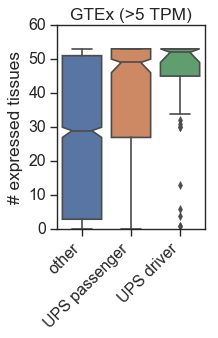

In [21]:
with sns.plotting_context('notebook', font_scale=1.3), sns.axes_style('ticks'):
    sns.boxplot('driver gene', '# expressed tissues', data=num_expr_df, 
                bootstrap=1000, notch=True, linewidth=None)
    plt.gcf().set_size_inches(3, 4.5)
    plt.title('GTEx (>5 TPM)')
    plt.xlabel('')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('figures/gtex.pdf')

Next, we wanted to test whether the differences in expression were statistically significant. 

In [22]:
# Mann-whitney U test
stat1, pval1 = stats.mannwhitneyu(num_expr_df.loc[num_expr_df['driver gene']=='UPS passenger', '# expressed tissues'],
                                  num_expr_df.loc[num_expr_df['driver gene']=='UPS driver', '# expressed tissues'])
stat2, pval2 = stats.mannwhitneyu(num_expr_df.loc[num_expr_df['driver gene']=='other', '# expressed tissues'],
                                  num_expr_df.loc[num_expr_df['driver gene']=='UPS driver', '# expressed tissues'])

# print results
print('Difference in number of expressed tissues between UPS drivers and UPS passengers (p={:.2g})'.format(pval1))
print('Difference in number of expressed tissues between UPS drivers and genes outside UPS (p={:.2g})'.format(pval2))

Difference in number of expressed tissues between UPS drivers and UPS passengers (p=0.0045)
Difference in number of expressed tissues between UPS drivers and genes outside UPS (p=2.2e-10)


### Gened dependency scores from CRISPR screens

From above, we found that our UPS driver gene set tended to be expressed in most normal tissues, but we reasoned that there could still be variability in how essential a gene is in various cancer cell lines.

In [23]:
# read in essentiality info
depmap_df = pd.read_csv('data/gtex_essentiality/depmap_std_ceres.txt', 
                        header=None, names=['gene', 'std'], sep='\t')
depmap_df = depmap_df[depmap_df['gene'].isin(protein_coding_genes)]

# label driver genes
depmap_df['driver gene'] = 'other'
depmap_df.loc[depmap_df.gene.isin(complete_ups), 'driver gene'] = 'UPS passenger'
depmap_df.loc[depmap_df.gene.isin(signif_genes), 'driver gene'] = 'UPS driver'

Next, plot the distribution of the standard deviation of CERES scores from DepMAP.

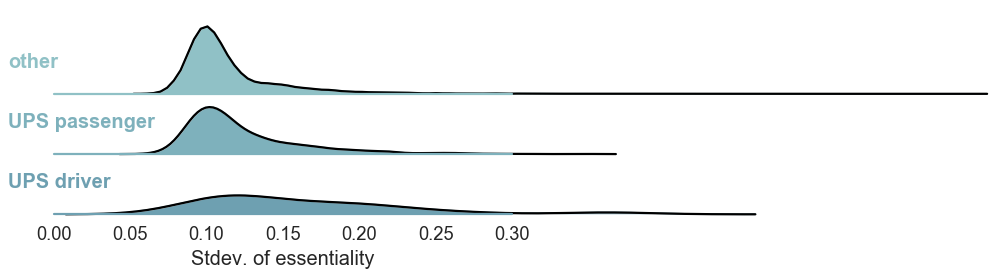

In [24]:
# format data for plotting
plot_df = depmap_df[['driver gene', 'std']].rename(
    columns={'driver gene': 'g', 'std': 'Stdev. of essentiality'}
).sort_values('g', ascending=False)

plot_params = {"axes.facecolor": (0, 0, 0, 0)}
with sns.axes_style('white', rc=plot_params), sns.plotting_context('notebook', font_scale=1.5):
    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(plot_df, row="g", hue="g", 
                      #aspect=15, 
                      aspect=8,
                      #height=.5, 
                      height=3,
                      palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "Stdev. of essentiality", clip_on=False, shade=True, alpha=1, lw=1.5,
          #bw=.2
         )
    g.map(sns.kdeplot, "Stdev. of essentiality", clip_on=False, color="black", lw=2, 
          #bw=.2
         )
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(-0.1, .4, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
    g.map(label, "Stdev. of essentiality")

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    plt.xlim(0, 0.3)
    plt.gcf().set_size_inches(6, 3)
    #plt.tight_layout()
    plt.savefig('figures/depmap_ceres_variability.pdf')

Next we test for statistical significance.

In [26]:
# Mann-whitney U test
stat1, pval1 = stats.mannwhitneyu(plot_df.loc[plot_df['g']=='UPS passenger', 'Stdev. of essentiality'],
                                  plot_df.loc[plot_df['g']=='UPS driver', 'Stdev. of essentiality'])
stat2, pval2 = stats.mannwhitneyu(plot_df.loc[plot_df['g']=='other', 'Stdev. of essentiality'],
                                  plot_df.loc[plot_df['g']=='UPS driver', 'Stdev. of essentiality'])

# print results
print('Difference in variability in essentiality between UPS drivers and UPS passengers (p={:.2g})'.format(pval1))
print('Difference in variability in essentiality between UPS drivers and genes outside UPS (p={:.2g})'.format(pval2))

Difference in variability in essentiality between UPS drivers and UPS passengers (p=3e-08)
Difference in variability in essentiality between UPS drivers and genes outside UPS (p=1.2e-13)


### Examine relative number of UPS drivers

Next, we look at what fraction of driver genes are related to the ubiquitin-proteasome system. The first step is to read in all the driver gene results.

In [27]:
# read driver gene results
result = utils.read_all_results_ups_dataframe()
result.loc[result['cancer type'].isin(['COAD', 'READ']), 'cancer type'] = 'COADREAD'
result = result.drop_duplicates(subset=['gene', 'cancer type'])

# read degron results
ub_df = utils.read_all_results_ub_sites()
phospho_df = utils.read_all_results_phosphodegron_sites()
phospho_df.loc[phospho_df['cancer type'].isin(['COAD', 'READ']), 'cancer type'] = 'COADREAD'
degron_df = utils.read_all_results_known_degron()

# read in TCGA PancanAtlas drivers
tcga_drivers = pd.read_table('data/misc/TCGA_pancanatlas_drivers.txt')

Next, merge all the driver gene results.

In [34]:
tcga_dict = dict(tcga_drivers.groupby('Cancer')['Gene'].unique())
ups_driver_dict = dict(result.groupby('cancer type')['gene'].unique())
degron_dict = dict(degron_df.groupby('cancer type')['gene'].unique())
phospho_dict = dict(phospho_df.groupby('cancer type')['gene'].unique())
ub_dict = dict(ub_df.groupby('cancer type')['gene'].unique())

#identified_drivers = utils.merge_dictionary(ups_driver_dict, degron_dict)
#identified_drivers = utils.merge_dictionary(identified_drivers, phospho_dict)
#identified_drivers = utils.merge_dictionary(identified_drivers, ub_dict)
identified_drivers = ups_driver_dict
all_drivers = utils.merge_dictionary(identified_drivers, tcga_dict)

identified_driver_cts = pd.Series({c: len(identified_drivers[c]) for c in identified_drivers})
all_driver_cts = pd.Series({c: len(all_drivers[c]) for c in all_drivers})

Now we plot the fraction of driver genes related to the UPS.

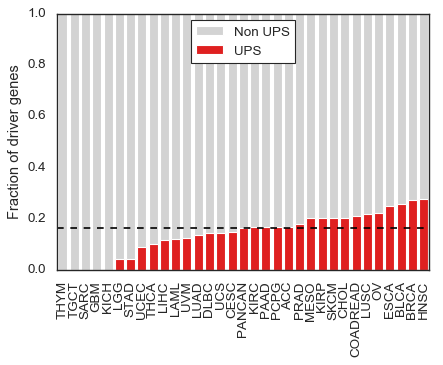

In [35]:
perct = (identified_driver_cts / all_driver_cts).fillna(0)
perct = perct.sort_values()
with sns.axes_style('white'), sns.plotting_context('notebook', font_scale=1.1):
    sns.barplot(perct.index, [1 for i in range(len(perct))], color='lightgray', label='Non UPS')
    sns.barplot(perct.index, perct, color='red', label='UPS')
    plt.xticks(rotation=90, ha='center')
    plt.axhline(perct.median(), linestyle='--', color='black')
    plt.ylabel('Fraction of driver genes')
    plt.legend(loc='upper center')
    plt.gcf().set_size_inches(6, 4)

In [36]:
perct.median()

0.16203703703703703

### Analyze co-mutational patterns with other driver genes

In this pare, we examine whether other putative driver genes tend to mutated in the same or different tumor as our identified UPS driver genes.

In [37]:
qval_thresh = 0.25
df_list = []
for f in glob.glob('data/ups_driver_gene/cooccur/*.txt'):
    ctype = os.path.basename(f)[:-4]
    tmp_df = pd.read_table(f)
    tmp_df['CODE'] = ctype
    df_list.append(tmp_df[tmp_df['qvalue']<=qval_thresh])
cooccur_df = pd.concat(df_list)

# annotate the type of interaction
cooccur_df['type'] = 'co-occur'
cooccur_df.loc[cooccur_df['odds.ratio']<1, 'type'] = 'mutually exclusive'

# rename with ctype if name
cooccur_df['ctype_first'] = cooccur_df['CODE'] + '_' + cooccur_df['first']
cooccur_df['ctype_second'] = cooccur_df['CODE'] + '_' + cooccur_df['second']

# change name of column
cooccur_df = cooccur_df.rename(columns={'CODE': 'Cancer Type'})

cooccur_df.head()

,first,second,odds.ratio,confidence.interval.low,confidence.interval.high,pvalue,qvalue,Cancer Type,type,ctype_first,ctype_second
163,MAP3K1,PIK3CA,2.442016,1.402611,4.274969,0.001184,0.170490,BRCA,co-occur,BRCA_MAP3K1,BRCA_PIK3CA
171,MAP3K1,TP53,0.265378,0.107480,0.571769,0.000138,0.039877,BRCA,mutually exclusive,BRCA_MAP3K1,BRCA_TP53
132,EP300,CASP8,4.905173,2.075743,11.098761,0.000154,0.055319,HNSC,co-occur,HNSC_EP300,HNSC_CASP8
170,FBXW7,FAT1,3.392571,1.556294,7.341764,0.001028,0.092251,HNSC,co-occur,HNSC_FBXW7,HNSC_FAT1
201,KMT2B,EPHA2,9.349742,2.317841,32.615317,0.001008,0.092251,HNSC,co-occur,HNSC_KMT2B,HNSC_EPHA2


In [193]:
cooccur_df[['Cancer Type', 'first', 'type', 'second']].to_csv('results/comutation_analysis.nnf', sep='\t', index=False, header=None)

### Categorize the UPS driver genes

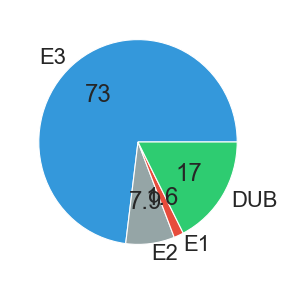

In [38]:
# mark each UPS gene with their function in the UPS
ups_df = utils.categorize_ups(signif_genes)

# plot the distribution
with sns.plotting_context('notebook', font_scale=1.8):
    category_cts = ups_df[['E3','E2', 'E1', 'DUB']].sum()
    flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", 
              #"#34495e", 
              "#2ecc71"]
    flatui_pal = sns.color_palette(flatui[1:])
    plt.pie(category_cts, 
            labels=category_cts.index,
            colors=flatui_pal,
            autopct='%.2G')
    plt.gcf().set_size_inches(4,4)
    plt.savefig('figures/ups_driver_categories.pdf')

### Prepare supplementary tables

In the last part of this notebook, we prepare the supplementary table for the manuscript.

In [10]:
ups_annot = utils.categorize_ups(complete_ups)
col_order = ['gene', 'E3', 'E2', 'E1', 'DUB']
ups_annot[col_order].to_excel('tables/TableS1.xlsx', sheet_name='ups annotation', index=False)

Save driver gene analysis

In [181]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('tables/TableS2.xlsx', engine='xlsxwriter')

# save each sheet
output_list = []
for f in glob.glob('data/ups_driver_gene/2020plus/*.txt'):
    ctype = os.path.basename(f)[:-4]
    tmp_df = pd.read_csv(f, sep='\t')
    tmp_df['type'] = tmp_df['info'].str[5:]
    is_high_score = tmp_df['score']>0.5
    is_signif = tmp_df['qvalue']<=0.05
    tmp_genes = tmp_df[is_high_score & is_signif]['gene'].unique()
    tmp_df = tmp_df[tmp_df['gene'].isin(tmp_genes)].copy()
    if len(tmp_df):
        tmp_df = pd.pivot_table(index='gene', 
                                 values=['score', 'pvalue', 'qvalue'], 
                                 columns=['type'], 
                                 data=tmp_df)[['score', 'pvalue', 'qvalue']]
        tmp_df.sort_values(('score', 'driver'), ascending=False, inplace=True)
        tmp_df['cancer type'] = ctype
        output_list.append(tmp_df)
    
write_df = pd.concat(output_list)[['cancer type', 'score', 'pvalue', 'qvalue']]
write_df.to_excel(writer, sheet_name='driver genes', float_format='%.2G')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

Next, mark which genes have been found previously.

In [187]:
# mark genes
ups_df['CGC'] = 0
ups_df['TCGA PancanAtlas'] = 0
ups_df['Ge et al.'] = 0
ups_df.loc[ups_df['gene'].isin(cgc), 'CGC'] = 1
ups_df.loc[ups_df['gene'].isin(tcga_drivers['Gene'].unique()), 'TCGA PancanAtlas'] = 1
ups_df.loc[ups_df['gene'].isin(ge_et_al_drivers), 'Ge et al.'] = 1

# save table
col_order = ['gene', 'CGC', 'TCGA PancanAtlas', 'Ge et al.', 'E3', 'E2', 'E1', 'DUB']
ups_df[col_order].to_excel('tables/TableS3.xlsx', sheet_name='ups annotation', index=False)

Save the co-mutation analysis as an excel file.

In [196]:
col_order = ['Cancer Type', 'first', 'second', 'odds.ratio', 'confidence.interval.low',
             'confidence.interval.high', 'pvalue', 'qvalue']
cooccur_df[col_order].to_excel('tables/TableS4.xlsx', sheet_name='comutation', index=False, float_format='%.2G')

In [94]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('tables/TableS2.xlsx', engine='xlsxwriter')

# save each sheet
for f in glob.glob('data/ups_driver_gene/2020plus/*.txt'):
    ctype = os.path.basename(f)[:-4]
    tmp_df = pd.read_csv(f, sep='\t')
    tmp_df['type'] = tmp_df['info'].str[5:]
    tmp_df = pd.pivot_table(index='gene', 
                             values=['score', 'pvalue', 'qvalue'], 
                             columns=['type'], 
                             data=tmp_df)[['score', 'pvalue', 'qvalue']]
    tmp_df.sort_values(('score', 'driver'), ascending=False, inplace=True)
    tmp_df.to_excel(writer, sheet_name=ctype, float_format='%.2G')

# Close the Pandas Excel writer and output the Excel file.
writer.save()